In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm  # 导入tqdm库


from Network import InceptionV4


### 1 Train a Network on CIFAR-10 

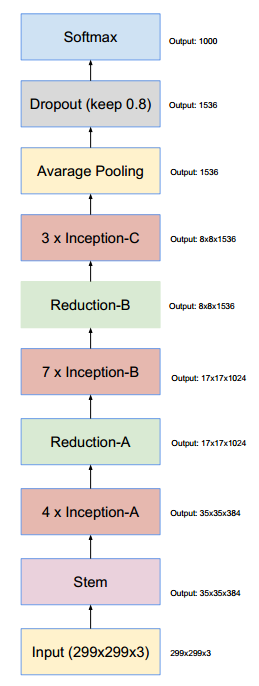

stem

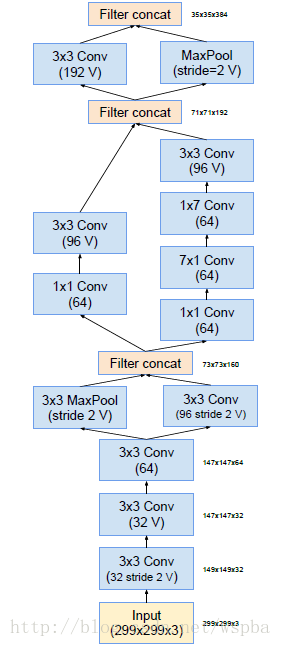

https://ar5iv.labs.arxiv.org/html/1602.07261?_immersive_translate_auto_translate=1

https://blog.csdn.net/qq_38807688/article/details/84590291

inception A

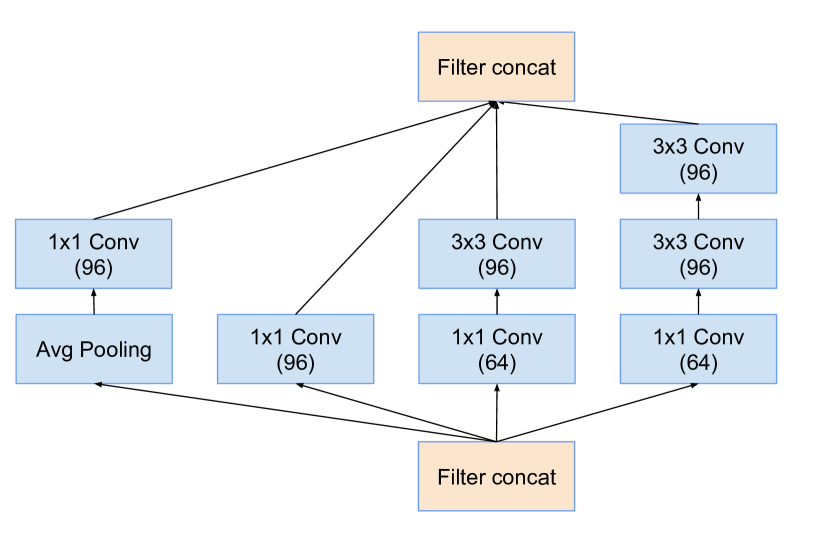

inception B

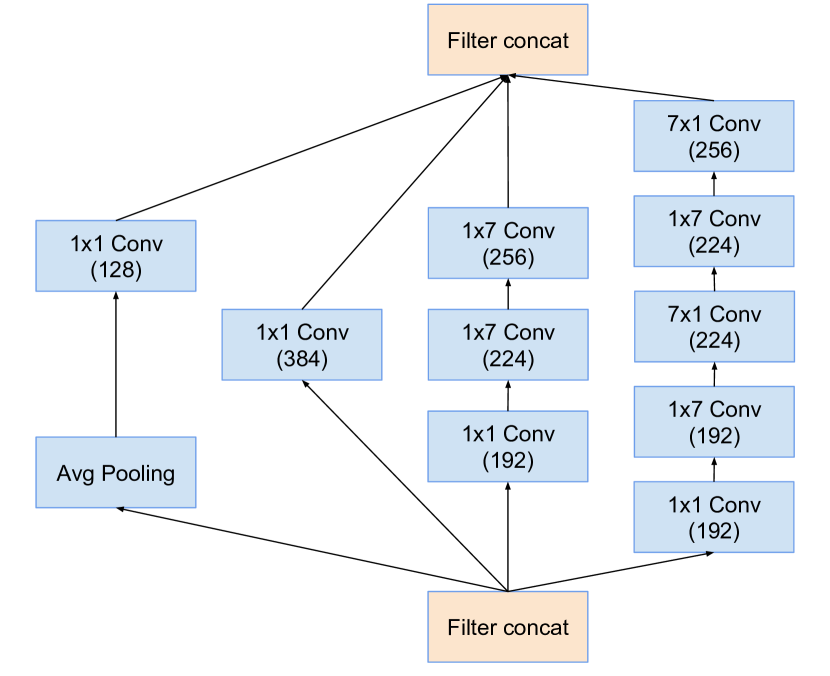

inception C


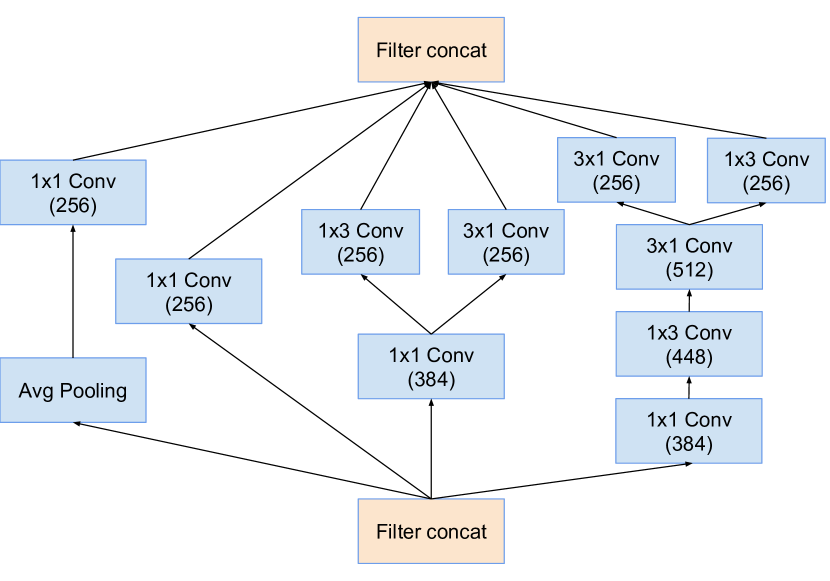

Redution A

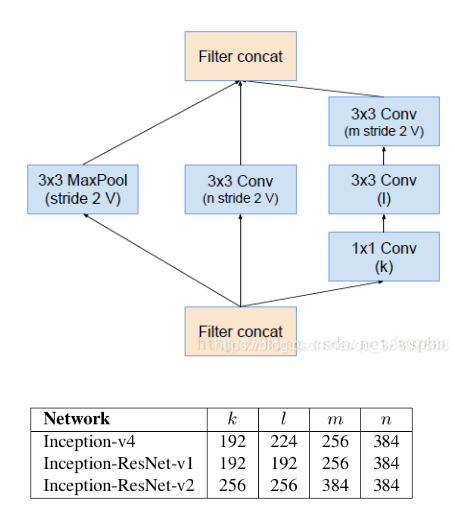

Redution B

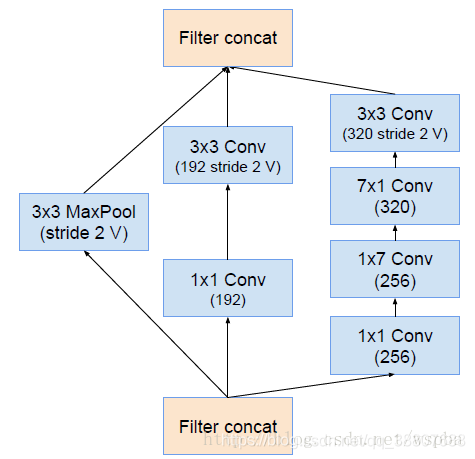

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = InceptionV4(num_classes=10).to(device)

In [3]:
# transform = transforms.Compose( [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5,
# 0.5))])
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [4]:
transform_train = transforms.Compose([
    transforms.Resize(299),  # 调整图像大小到299x299, inception 架构
    transforms.RandomCrop(299, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(299),  # 调整图像大小到299x299
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载CIFAR-10数据集
trainset =  torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset =  torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
testloader = DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
def train(epoch):
    model.train()
    running_loss = 0.0
    epoch_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss += loss.item()
        if batch_idx % 100 == 99:  # 每100个批次打印一次
            print(f'Epoch [{epoch+1}], Step [{batch_idx+1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0
    return epoch_loss / len(trainloader)

def test():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# 初始化列表以记录训练损失和测试精度
train_losses = []
test_accuracies = []

# 执行训练和测试
for epoch in range(100):  # 训练100个epoch
    train_loss = train(epoch)
    train_losses.append(train_loss)
    test_accuracy = test()
    test_accuracies.append(test_accuracy)

# 绘制损失图像
plt.figure()
plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# 输出最终的结果
print(f'Final Training Loss: {train_losses[-1]:.4f}')
print(f'Final Test Accuracy: {test_accuracies[-1]:.2f}%')


Epoch [1], Step [100/12500], Loss: 276420032865486897152.0000
Epoch [1], Step [200/12500], Loss: 271218585380354784.0000
Epoch [1], Step [300/12500], Loss: 17644296694713548.0000
Epoch [1], Step [400/12500], Loss: 10155475827110708.0000
Epoch [1], Step [500/12500], Loss: 8775250855885537.0000
Epoch [1], Step [600/12500], Loss: 5806533487183790.0000
Epoch [1], Step [700/12500], Loss: 3443316528324280.5000
Epoch [1], Step [800/12500], Loss: 3806085572271800.5000
Epoch [1], Step [900/12500], Loss: 3047334776080957.5000
Epoch [1], Step [1000/12500], Loss: 2260685084153610.0000
Epoch [1], Step [1100/12500], Loss: 2261097745282498.5000
Epoch [1], Step [1200/12500], Loss: 1856583258855178.2500
Epoch [1], Step [1300/12500], Loss: 1571111213947945.0000
Epoch [1], Step [1400/12500], Loss: 1324023324983951.2500
Epoch [1], Step [1500/12500], Loss: 1362005556880998.5000
Epoch [1], Step [1600/12500], Loss: 1047420335449702.3750
Epoch [1], Step [1700/12500], Loss: 989898751554355.2500
Epoch [1], Step

KeyboardInterrupt: 

训练缓慢且效果不显著

In [ ]:
torch.cuda.empty_cache()
